In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Carregar os dados de vocalização do grupo Água e Bosque
arquivo_agua = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
arquivo_bosque = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Carregar os dados de temperatura e chuva
arquivo_temperatura = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Temperatura1.xlsx'
df_temperatura = pd.read_excel(arquivo_temperatura)

# Função para calcular média diária e filtrar vocalizações
def calcular_media_diaria_vocalizacao(arquivo, classificacao='phee adulto', duracao_limite=0.0):
    df = pd.concat(pd.read_excel(arquivo, sheet_name=None), ignore_index=True)
    df_filtrado = df[(df['Classificacao'] == classificacao) & (df['Tempototal'] >= duracao_limite)]
    media_diaria = df_filtrado.groupby('Data')['Tempototal'].mean().reset_index()
    # Converter 'Data' para datetime
    media_diaria['Data'] = pd.to_datetime(media_diaria['Data'])
    return media_diaria


# Calcular média diária de vocalização para Água e Bosque
media_diaria_agua = calcular_media_diaria_vocalizacao(arquivo_agua)
media_diaria_bosque = calcular_media_diaria_vocalizacao(arquivo_bosque)

# Calcular média diária de temperatura e chuva
df_temperatura['Data'] = pd.to_datetime(df_temperatura['DataHora']).dt.date
media_diaria_temperatura = df_temperatura.groupby('Data')['Temperatura'].mean().reset_index()
media_diaria_chuva = df_temperatura.groupby('Data')['Chuva'].mean().reset_index()

# Converter 'Data' para datetime
media_diaria_temperatura['Data'] = pd.to_datetime(media_diaria_temperatura['Data'])
media_diaria_chuva['Data'] = pd.to_datetime(media_diaria_chuva['Data'])

# Mesclar os DataFrames usando 'pd.merge' ou 'pd.concat' para o grupo Água
df_final_agua = pd.merge(media_diaria_agua, media_diaria_temperatura, on='Data', how='outer')
df_final_agua = pd.merge(df_final_agua, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames usando 'pd.merge' ou 'pd.concat' para o grupo Bosque
df_final_bosque = pd.merge(media_diaria_bosque, media_diaria_temperatura, on='Data', how='outer')
df_final_bosque = pd.merge(df_final_bosque, media_diaria_chuva, on='Data', how='outer')

# Remover linhas com valores nulos para o grupo Água
df_final_agua.dropna(inplace=True)

# Remover linhas com valores nulos para o grupo Bosque
df_final_bosque.dropna(inplace=True)

# Preparar dados para regressão múltipla para o grupo Água
X_agua = df_final_agua[['Temperatura', 'Chuva']]
y_agua = df_final_agua['Tempototal']

# Preparar dados para regressão múltipla para o grupo Bosque
X_bosque = df_final_bosque[['Temperatura', 'Chuva']]
y_bosque = df_final_bosque['Tempototal']

# Criar modelo de regressão linear para o grupo Água
modelo_agua = LinearRegression()
modelo_agua.fit(X_agua, y_agua)

# Criar modelo de regressão linear para o grupo Bosque
modelo_bosque = LinearRegression()
modelo_bosque.fit(X_bosque, y_bosque)



LinearRegression()

         Data  Tempototal  Temperatura       Chuva
0  2022-09-09    1.105715    26.478112    0.000000
1  2022-09-16    1.379143    27.002359    1.340173
2  2022-10-05    0.887532    27.805976    1.230725
3  2022-10-07    0.923823    28.389356    7.740057
4  2022-10-24    0.694286    28.324300    2.682021
5  2022-10-26    1.339543    27.816891    0.322200
6  2022-10-28    1.312420    28.216392    2.125291
7  2022-11-07    1.349524    27.901807   10.800119
8  2022-11-09    1.288571    28.177120    0.813038
9  2022-11-11    1.352550    28.675359    1.926499
10 2022-11-28    1.531422    28.251046   14.646415
11 2022-12-05    1.154691    27.291828    5.782288
12 2022-12-07    1.511469    28.331928    1.278748
13 2022-12-09    1.413600    28.362057    6.432272
14 2022-12-19    1.316143    28.133943    0.248490
15 2022-12-23    1.430204    27.760179   17.769576
16 2023-01-01    1.242857    27.140136    8.329175
17 2023-01-23    0.754286    28.399490   19.020963
18 2023-02-13    1.376491    28

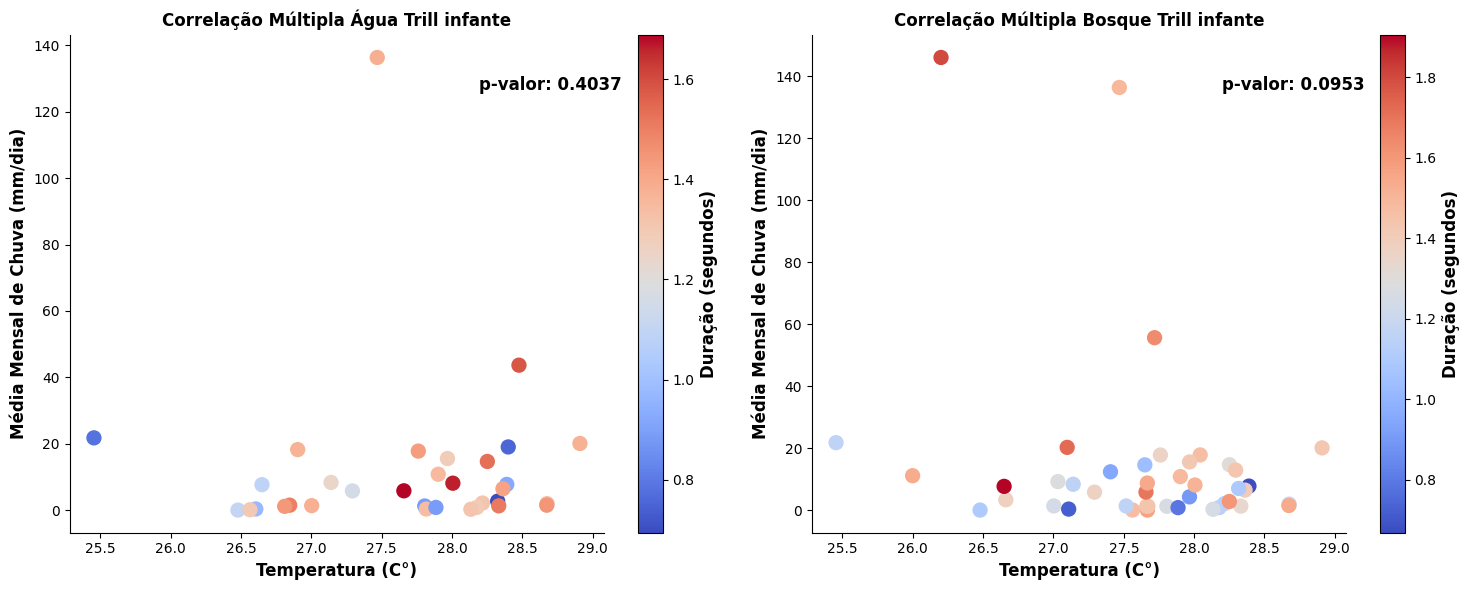

In [18]:
print(df_final_agua)
def plot_correlacao_grupo(ax, df, grupo):
    if 'Temperatura' in df.columns and 'Chuva' in df.columns:
        X = df[['Temperatura', 'Chuva']]
        y = df['Tempototal']
        
        # Adicionar constante para o modelo de regressão
        X = sm.add_constant(X)
        
        # Criar modelo de regressão linear usando statsmodels
        modelo = sm.OLS(y, X)
        resultado = modelo.fit()
        
        # Extrair R^2 e p-valor da regressão
        r2 = resultado.rsquared
        p_valor = resultado.f_pvalue
        
        # Plotar gráfico de dispersão com correlação
        scatter = ax.scatter(x='Temperatura', y='Chuva', c='Tempototal', cmap='coolwarm', s=100, data=df)
        ax.set_title(f'Correlação Múltipla {grupo} Trill infante', size=12, weight="bold")
        ax.set_xlabel('Temperatura (C°)', size=12, weight="bold")
        ax.set_ylabel('Média Mensal de Chuva (mm/dia)', size=12, weight="bold")
        
        # Adicionar barra de cores manualmente
        cbar = plt.colorbar(scatter, ax=ax, label='Duração (segundos)')
        cbar.ax.set_ylabel('Duração (segundos)', size=12, weight="bold")  # ajusta o título da barra de cores
        
        # Adicionar texto com o valor de p-valor
        texto_p_valor = f'p-valor: {p_valor:.4f}'
        ax.text(0.9, 0.9, texto_p_valor, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, weight="bold")
        # Remover as bordas superior e direita
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Restante do seu código...

# Criar figura e eixos para os subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotar correlação para o grupo Água
plot_correlacao_grupo(axs[0], df_final_agua, 'Água')

# Plotar correlação para o grupo Bosque
plot_correlacao_grupo(axs[1], df_final_bosque, 'Bosque')

# Ajustar layout e mostrar os gráficos
plt.tight_layout()
# plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação múltipla trill bb.png', bbox_inches='tight')

plt.show()

In [49]:
#correlação multipla phee e trill adulto 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Carregar os dados de vocalização do grupo Água e Bosque
arquivo_agua = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
arquivo_bosque = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Carregar os dados de temperatura e chuva
arquivo_temperatura = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Temperatura1.xlsx'
df_temperatura = pd.read_excel(arquivo_temperatura)

# Função para calcular média diária e filtrar vocalizações
def calcular_media_diaria_vocalizacao(arquivo, tipo_vocalizacao='phee adulto', duracao_limite=0.0):
    df = pd.concat(pd.read_excel(arquivo, sheet_name=None), ignore_index=True)
    df_filtrado = df[(df['Classificacao'] == tipo_vocalizacao) & (df['Tempototal'] >= duracao_limite)]
    media_diaria = df_filtrado.groupby('Data')['Tempototal'].mean().reset_index()
    media_diaria['Data'] = pd.to_datetime(media_diaria['Data'])
    return media_diaria

# Calcular média diária de vocalização para Água e Bosque, considerando 'phee adulto' e 'trill adulto'
media_diaria_phee_agua = calcular_media_diaria_vocalizacao(arquivo_agua, tipo_vocalizacao='phee adulto')
media_diaria_trill_agua = calcular_media_diaria_vocalizacao(arquivo_agua, tipo_vocalizacao='trill adulto')
media_diaria_phee_bosque = calcular_media_diaria_vocalizacao(arquivo_bosque, tipo_vocalizacao='phee adulto')
media_diaria_trill_bosque = calcular_media_diaria_vocalizacao(arquivo_bosque, tipo_vocalizacao='trill adulto')

# Calcular média diária de temperatura e chuva
df_temperatura['Data'] = pd.to_datetime(df_temperatura['DataHora']).dt.date
media_diaria_temperatura = df_temperatura.groupby('Data')['Temperatura'].mean().reset_index()
media_diaria_chuva = df_temperatura.groupby('Data')['Chuva'].mean().reset_index()

# Converter 'Data' para datetime
media_diaria_temperatura['Data'] = pd.to_datetime(media_diaria_temperatura['Data'])
media_diaria_chuva['Data'] = pd.to_datetime(media_diaria_chuva['Data'])

# Mesclar os DataFrames para o grupo Água (phee adulto)
df_final_agua_phee = pd.merge(media_diaria_phee_agua, media_diaria_temperatura, on='Data', how='outer')
df_final_agua_phee = pd.merge(df_final_agua_phee, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Água (trill adulto)
df_final_agua_trill = pd.merge(media_diaria_trill_agua, media_diaria_temperatura, on='Data', how='outer')
df_final_agua_trill = pd.merge(df_final_agua_trill, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Bosque (phee adulto)
df_final_bosque_phee = pd.merge(media_diaria_phee_bosque, media_diaria_temperatura, on='Data', how='outer')
df_final_bosque_phee = pd.merge(df_final_bosque_phee, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Bosque (trill adulto)
df_final_bosque_trill = pd.merge(media_diaria_trill_bosque, media_diaria_temperatura, on='Data', how='outer')
df_final_bosque_trill = pd.merge(df_final_bosque_trill, media_diaria_chuva, on='Data', how='outer')

# Remover linhas com valores nulos para o grupo Bosque
df_final_bosque_phee.dropna(inplace=True)
df_final_bosque_trill.dropna(inplace=True)
df_final_agua_phee.dropna(inplace=True)
df_final_agua_trill.dropna(inplace=True)

# Renomear as colunas nos DataFrames finais
df_final_agua_phee.rename(columns={'Tempototal':'phee adulto'}, inplace=True)
df_final_agua_trill.rename(columns={'Tempototal':'trill adulto'}, inplace=True)
df_final_bosque_phee.rename(columns={'Tempototal':'phee adulto'}, inplace=True)
df_final_bosque_trill.rename(columns={'Tempototal':'trill adulto'}, inplace=True)
print(df_final_bosque_trill)
# Preparar dados para regressão múltipla para o grupo Água (usando 'phee adulto')
X_agua_phee = df_final_agua_phee[['phee adulto', 'Temperatura', 'Chuva']]
y_agua_phee = df_final_agua_phee['phee adulto']

# Criar modelo de regressão linear para o grupo Água (usando 'phee adulto')
modelo_agua_phee = LinearRegression()
modelo_agua_phee.fit(X_agua_phee, y_agua_phee)

# Preparar dados para regressão múltipla para o grupo Água (usando 'trill adulto')
X_agua_trill = df_final_agua_trill[['trill adulto', 'Temperatura', 'Chuva']]
y_agua_trill = df_final_agua_trill['trill adulto']

# Criar modelo de regressão linear para o grupo Água (usando 'trill adulto')
modelo_agua_trill = LinearRegression()
modelo_agua_trill.fit(X_agua_trill, y_agua_trill)

# Preparar dados para regressão múltipla para o grupo Bosque (usando 'phee adulto')
X_bosque_phee = df_final_bosque_phee[['phee adulto', 'Temperatura', 'Chuva']]
y_bosque_phee = df_final_bosque_phee['phee adulto']

# Criar modelo de regressão linear para o grupo Bosque (usando 'phee adulto')
modelo_bosque_phee = LinearRegression()
modelo_bosque_phee.fit(X_bosque_phee, y_bosque_phee)

# Preparar dados para regressão múltipla para o grupo Bosque (usando 'trill adulto')
X_bosque_trill = df_final_bosque_trill[['trill adulto', 'Temperatura', 'Chuva']]
y_bosque_trill = df_final_bosque_trill['trill adulto']

# Criar modelo de regressão linear para o grupo Bosque (usando 'trill adulto')
modelo_bosque_trill = LinearRegression()
modelo_bosque_trill.fit(X_bosque_trill, y_bosque_trill)



         Data  trill adulto  Temperatura      Chuva
0  2022-08-26      0.415014    25.705482   0.051932
1  2022-09-21      0.334286    27.068706   0.097163
2  2022-10-03      0.428572    27.667877   0.000000
3  2022-10-07      0.548571    28.389356   7.740057
4  2022-11-09      0.538857    28.177120   0.813038
5  2022-11-28      0.600293    28.251046  14.646415
6  2022-11-30      0.494143    28.042817  17.795263
7  2022-12-05      0.620425    27.291828   5.782288
8  2022-12-17      0.448018    27.966735   4.267334
9  2022-12-19      0.694286    28.133943   0.248490
10 2023-01-23      0.377143    28.399490  19.020963
11 2023-01-25      0.610714    27.395697  25.106464
12 2023-01-27      0.485714    28.071706   5.695735
13 2023-02-13      0.576000    28.909216  20.066297
14 2023-02-15      0.705714    28.475733  43.654458
15 2023-02-17      0.563377    28.673384   1.479216
16 2023-03-06      0.574286    28.316141   6.979509
17 2023-05-14      0.591429    27.718638  55.615501
18 2023-05-1

LinearRegression()

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_correlacao_grupo(ax, df, grupo, tipo_vocalizacao):
    X = df[['Temperatura', 'Chuva']]
    y = df[tipo_vocalizacao]
    
    # Adicionar constante para o modelo de regressão
    X = sm.add_constant(X)
    
    # Criar modelo de regressão linear usando statsmodels
    modelo = sm.OLS(y, X)
    resultado = modelo.fit()
    
    # Extrair R^2 e p-valor da regressão
    r2 = resultado.rsquared
    p_valor = resultado.f_pvalue
    
    # Plotar gráfico de dispersão com correlação
    scatter = ax.scatter(x='Temperatura', y='Chuva', c=tipo_vocalizacao, cmap='coolwarm', s=100, data=df)
    ax.set_title(f' {grupo} {tipo_vocalizacao}', size=15, weight="bold")
    ax.set_xlabel('Temperatura (C°)', size=15, weight="bold")
    ax.set_ylabel('Média Mensal de Chuva (mm/dia)', size=15, weight="bold")
    
    # Adicionar barra de cores manualmente
    cbar = plt.colorbar(scatter, ax=ax, label='Duração (segundos)')
    cbar.ax.set_ylabel('Duração (segundos)', size=15, weight="bold")  # ajusta o título da barra de cores
    
    # Adicionar texto com o valor de p-valor
    texto_p_valor = f'p-valor: {p_valor:.4f}'
    ax.text(0.9, 0.9, texto_p_valor, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, weight="bold")
    
    # Configurar os ticks e labels do eixo x
    plt.sca(ax)  # Define o eixo atual como ax
    plt.xticks(fontsize=15, weight='bold')
    
    # Configurar os ticks e labels do eixo y
    plt.yticks(fontsize=15, weight='bold')
    
    # Remover as bordas superior e direita
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Criar figura e eixos para os subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plotar correlação para 'phee adulto' Água
plot_correlacao_grupo(axs[0, 0], df_final_agua_phee, 'Água', 'phee adulto')

# Plotar correlação para 'trill adulto' Água
plot_correlacao_grupo(axs[0, 1], df_final_agua_trill, 'Água', 'trill adulto')

# Plotar correlação para 'phee adulto' Bosque
plot_correlacao_grupo(axs[1, 0], df_final_bosque_phee, 'Bosque', 'phee adulto')

# Plotar correlação para 'trill adulto' Bosque
plot_correlacao_grupo(axs[1, 1], df_final_bosque_trill, 'Bosque', 'trill adulto')

# Ajustar layout e mostrar os gráficos
plt.tight_layout()
# plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação multipla adulto.png', bbox_inches='tight')

plt.show()

NameError: name 'df_final_agua' is not defined

In [1]:
#correlação multipla phee e trill infante  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Carregar os dados de vocalização do grupo Água e Bosque
arquivo_agua = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
arquivo_bosque = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Carregar os dados de temperatura e chuva
arquivo_temperatura = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Temperatura1.xlsx'
df_temperatura = pd.read_excel(arquivo_temperatura)

# Função para calcular média diária e filtrar vocalizações
def calcular_media_diaria_vocalizacao(arquivo, tipo_vocalizacao='phee bb', duracao_limite=0.0):
    df = pd.concat(pd.read_excel(arquivo, sheet_name=None), ignore_index=True)
    df_filtrado = df[(df['Classificacao'] == tipo_vocalizacao) & (df['Tempototal'] >= duracao_limite)]
    media_diaria = df_filtrado.groupby('Data')['Tempototal'].mean().reset_index()
    media_diaria['Data'] = pd.to_datetime(media_diaria['Data'])
    return media_diaria

# Calcular média diária de vocalização para Água e Bosque, considerando 'phee adulto' e 'trill adulto'
media_diaria_phee_agua = calcular_media_diaria_vocalizacao(arquivo_agua, tipo_vocalizacao='phee adulto')
media_diaria_trill_agua = calcular_media_diaria_vocalizacao(arquivo_agua, tipo_vocalizacao='trill adulto')
media_diaria_phee_bosque = calcular_media_diaria_vocalizacao(arquivo_bosque, tipo_vocalizacao='phee adulto')
media_diaria_trill_bosque = calcular_media_diaria_vocalizacao(arquivo_bosque, tipo_vocalizacao='trill adulto')

# Calcular média diária de temperatura e chuva
df_temperatura['Data'] = pd.to_datetime(df_temperatura['DataHora']).dt.date
media_diaria_temperatura = df_temperatura.groupby('Data')['Temperatura'].mean().reset_index()
media_diaria_chuva = df_temperatura.groupby('Data')['Chuva'].mean().reset_index()

# Converter 'Data' para datetime
media_diaria_temperatura['Data'] = pd.to_datetime(media_diaria_temperatura['Data'])
media_diaria_chuva['Data'] = pd.to_datetime(media_diaria_chuva['Data'])

# Mesclar os DataFrames para o grupo Água (phee adulto)
df_final_agua_phee = pd.merge(media_diaria_phee_agua, media_diaria_temperatura, on='Data', how='outer')
df_final_agua_phee = pd.merge(df_final_agua_phee, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Água (trill adulto)
df_final_agua_trill = pd.merge(media_diaria_trill_agua, media_diaria_temperatura, on='Data', how='outer')
df_final_agua_trill = pd.merge(df_final_agua_trill, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Bosque (phee adulto)
df_final_bosque_phee = pd.merge(media_diaria_phee_bosque, media_diaria_temperatura, on='Data', how='outer')
df_final_bosque_phee = pd.merge(df_final_bosque_phee, media_diaria_chuva, on='Data', how='outer')

# Mesclar os DataFrames para o grupo Bosque (trill adulto)
df_final_bosque_trill = pd.merge(media_diaria_trill_bosque, media_diaria_temperatura, on='Data', how='outer')
df_final_bosque_trill = pd.merge(df_final_bosque_trill, media_diaria_chuva, on='Data', how='outer')

# Remover linhas com valores nulos para o grupo Bosque
df_final_bosque_phee.dropna(inplace=True)
df_final_bosque_trill.dropna(inplace=True)
df_final_agua_phee.dropna(inplace=True)
df_final_agua_trill.dropna(inplace=True)

# Renomear as colunas nos DataFrames finais
df_final_agua_phee.rename(columns={'Tempototal':'phee infante'}, inplace=True)
df_final_agua_trill.rename(columns={'Tempototal':'trill infante'}, inplace=True)
df_final_bosque_phee.rename(columns={'Tempototal':'phee infante'}, inplace=True)
df_final_bosque_trill.rename(columns={'Tempototal':'trill infante'}, inplace=True)
print(df_final_bosque_trill)
# Preparar dados para regressão múltipla para o grupo Água (usando 'phee adulto')
X_agua_phee = df_final_agua_phee[['phee infante', 'Temperatura', 'Chuva']]
y_agua_phee = df_final_agua_phee['phee infante']

# Criar modelo de regressão linear para o grupo Água (usando 'phee adulto')
modelo_agua_phee = LinearRegression()
modelo_agua_phee.fit(X_agua_phee, y_agua_phee)

# Preparar dados para regressão múltipla para o grupo Água (usando 'trill adulto')
X_agua_trill = df_final_agua_trill[['trill infante', 'Temperatura', 'Chuva']]
y_agua_trill = df_final_agua_trill['trill infante']

# Criar modelo de regressão linear para o grupo Água (usando 'trill adulto')
modelo_agua_trill = LinearRegression()
modelo_agua_trill.fit(X_agua_trill, y_agua_trill)

# Preparar dados para regressão múltipla para o grupo Bosque (usando 'phee adulto')
X_bosque_phee = df_final_bosque_phee[['phee infante', 'Temperatura', 'Chuva']]
y_bosque_phee = df_final_bosque_phee['phee infante']

# Criar modelo de regressão linear para o grupo Bosque (usando 'phee adulto')
modelo_bosque_phee = LinearRegression()
modelo_bosque_phee.fit(X_bosque_phee, y_bosque_phee)

# Preparar dados para regressão múltipla para o grupo Bosque (usando 'trill adulto')
X_bosque_trill = df_final_bosque_trill[['trill infante', 'Temperatura', 'Chuva']]
y_bosque_trill = df_final_bosque_trill['trill infante']

# Criar modelo de regressão linear para o grupo Bosque (usando 'trill adulto')
modelo_bosque_trill = LinearRegression()
modelo_bosque_trill.fit(X_bosque_trill, y_bosque_trill)


         Data  trill infante  Temperatura      Chuva
0  2022-08-26       0.415014    25.705482   0.051932
1  2022-09-21       0.334286    27.068706   0.097163
2  2022-10-03       0.428572    27.667877   0.000000
3  2022-10-07       0.548571    28.389356   7.740057
4  2022-11-09       0.538857    28.177120   0.813038
5  2022-11-28       0.600293    28.251046  14.646415
6  2022-11-30       0.494143    28.042817  17.795263
7  2022-12-05       0.620425    27.291828   5.782288
8  2022-12-17       0.448018    27.966735   4.267334
9  2022-12-19       0.694286    28.133943   0.248490
10 2023-01-23       0.377143    28.399490  19.020963
11 2023-01-25       0.610714    27.395697  25.106464
12 2023-01-27       0.485714    28.071706   5.695735
13 2023-02-13       0.576000    28.909216  20.066297
14 2023-02-15       0.705714    28.475733  43.654458
15 2023-02-17       0.563377    28.673384   1.479216
16 2023-03-06       0.574286    28.316141   6.979509
17 2023-05-14       0.591429    27.718638  55.

LinearRegression()

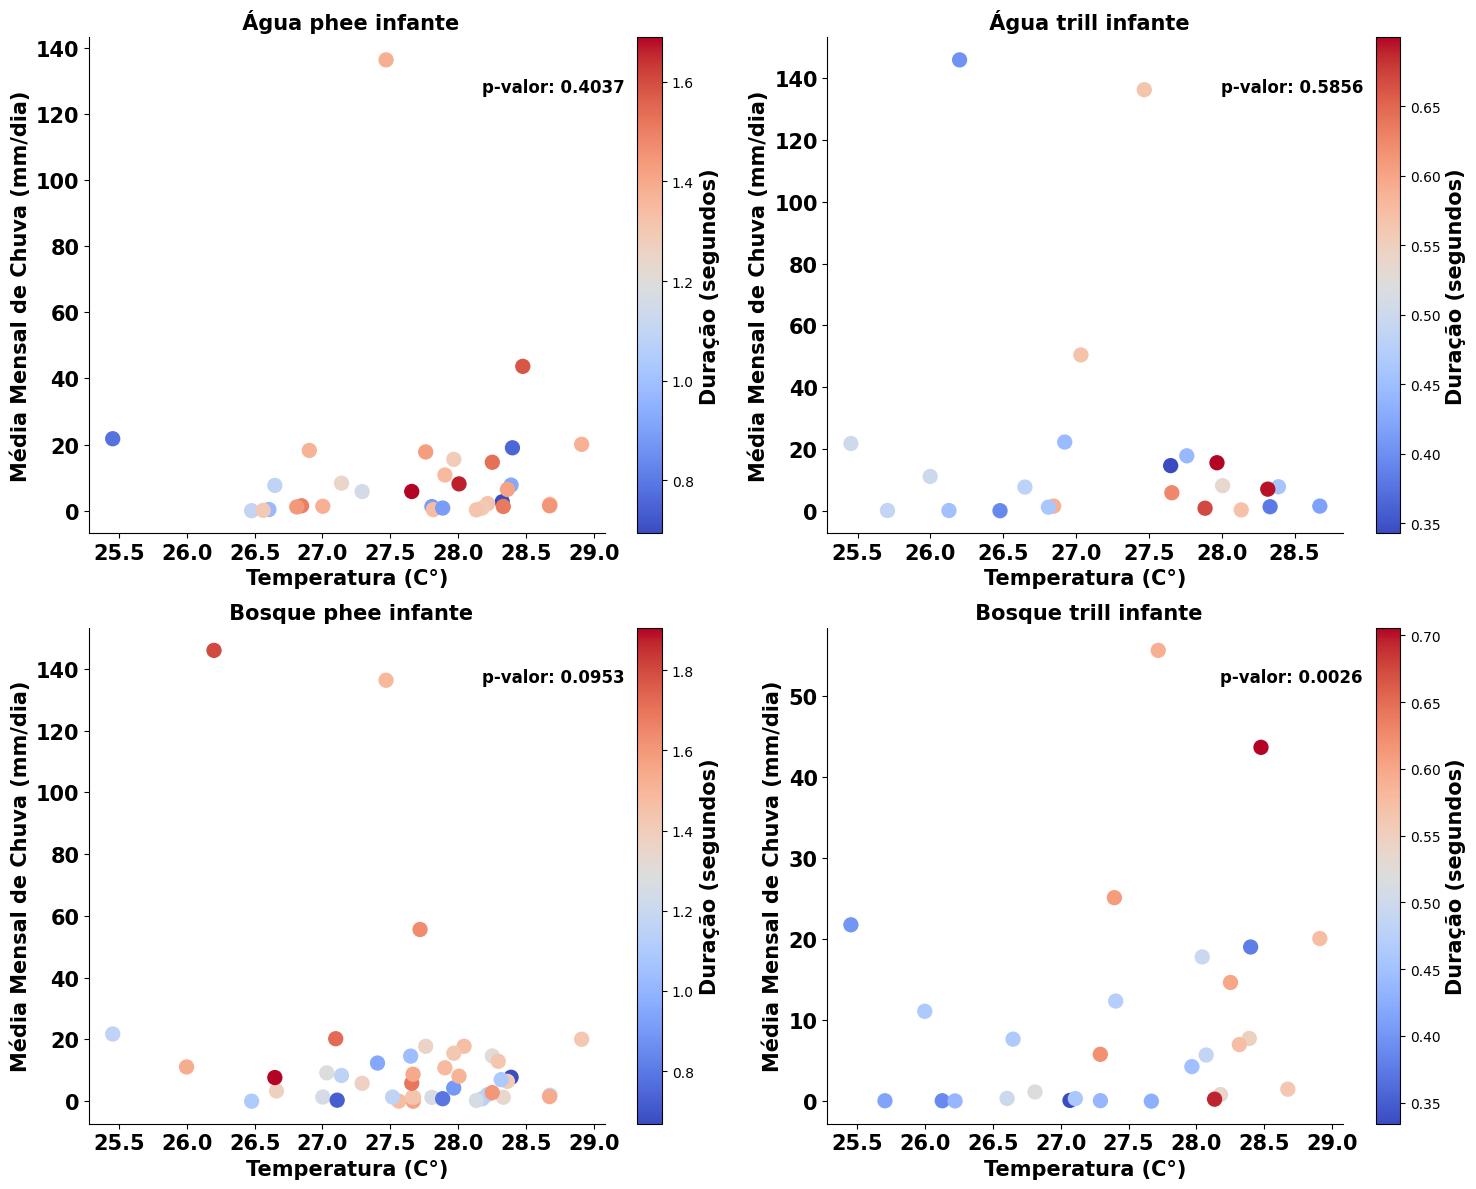

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_correlacao_grupo(ax, df, grupo, tipo_vocalizacao):
    X = df[['Temperatura', 'Chuva']]
    y = df[tipo_vocalizacao]
    
    # Adicionar constante para o modelo de regressão
    X = sm.add_constant(X)
    
    # Criar modelo de regressão linear usando statsmodels
    modelo = sm.OLS(y, X)
    resultado = modelo.fit()
    
    # Extrair R^2 e p-valor da regressão
    r2 = resultado.rsquared
    p_valor = resultado.f_pvalue
    
    # Plotar gráfico de dispersão com correlação
    scatter = ax.scatter(x='Temperatura', y='Chuva', c=tipo_vocalizacao, cmap='coolwarm', s=100, data=df)
    ax.set_title(f' {grupo} {tipo_vocalizacao}', size=15, weight="bold")
    ax.set_xlabel('Temperatura (C°)', size=15, weight="bold")
    ax.set_ylabel('Média Mensal de Chuva (mm/dia)', size=15, weight="bold")
    
    # Adicionar barra de cores manualmente
    cbar = plt.colorbar(scatter, ax=ax, label='Duração (segundos)')
    cbar.ax.set_ylabel('Duração (segundos)', size=15, weight="bold")  # ajusta o título da barra de cores
    
    # Adicionar texto com o valor de p-valor
    texto_p_valor = f'p-valor: {p_valor:.4f}'
    ax.text(0.9, 0.9, texto_p_valor, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, weight="bold")
    
    # Configurar os ticks e labels do eixo x
    plt.sca(ax)  # Define o eixo atual como ax
    plt.xticks(fontsize=15, weight='bold')
    
    # Configurar os ticks e labels do eixo y
    plt.yticks(fontsize=15, weight='bold')
    
    # Remover as bordas superior e direita
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Criar figura e eixos para os subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plotar correlação para 'phee adulto' Água
plot_correlacao_grupo(axs[0, 0], df_final_agua_phee, 'Água', 'phee infante')

# Plotar correlação para 'trill adulto' Água
plot_correlacao_grupo(axs[0, 1], df_final_agua_trill, 'Água', 'trill infante')

# Plotar correlação para 'phee adulto' Bosque
plot_correlacao_grupo(axs[1, 0], df_final_bosque_phee, 'Bosque', 'phee infante')

# Plotar correlação para 'trill adulto' Bosque
plot_correlacao_grupo(axs[1, 1], df_final_bosque_trill, 'Bosque', 'trill infante')

# Ajustar layout e mostrar os gráficos
plt.tight_layout()
# plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação multipla infante.png', bbox_inches='tight')

plt.show()